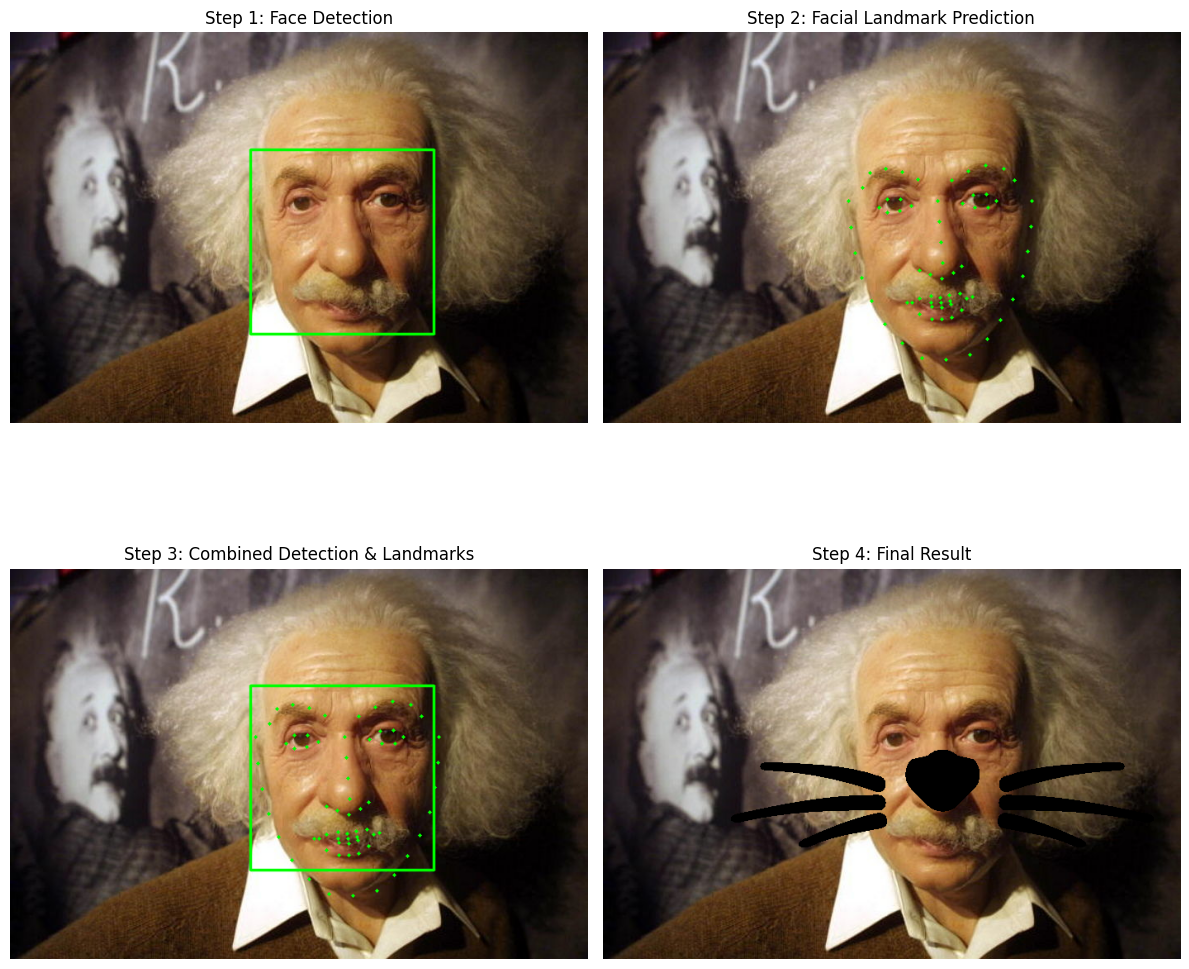

In [5]:
# Import the necessary libraries for the script.
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# --- 1. Setup & model loading---
home_dir = os.getenv('HOME')
detector_hog = dlib.get_frontal_face_detector()
# Model Path
model_path = os.path.join(home_dir, 'desktop/work/models/shape_predictor_68_face_landmarks.dat')
landmark_predictor = dlib.shape_predictor(model_path)

# Load images
img_bgr = cv2.imread('einstein.jpg')
img_sticker = cv2.imread('cat-whiskers.png')

# Run the face detector
dlib_rects = detector_hog(img_bgr, 1)

# --- 2. Visualization prep here ---

# Visualization for Step 1: Face Detection Box 
img_show_step1 = img_bgr.copy()
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show_step1, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

# Visualization for Step 2: Facial Landmarks 
img_show_step2 = img_bgr.copy()
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr, dlib_rect)
    for p in points.parts():
        cv2.circle(img_show_step2, (p.x, p.y), 2, (0, 255, 0), -1)

# Visualization for Step 3: Box & Landmarks
img_show_step3 = img_bgr.copy()
for dlib_rect in dlib_rects:
    # Draw the rectangle
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show_step3, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    # Draw the landmarks
    points = landmark_predictor(img_bgr, dlib_rect)
    for p in points.parts():
        cv2.circle(img_show_step3, (p.x, p.y), 2, (0, 255, 0), -1)

# Visualization for Step 4: Apply the Sticker (Final Result)
img_show_step4 = img_bgr.copy()
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr, dlib_rect)
    nose_tip = points.part(30)
    
    # Use a temporary sticker image to avoid modifying the original during boundary checks
    temp_sticker = img_sticker.copy()
    
    refined_x = nose_tip.x - (temp_sticker.shape[1] // 2)
    refined_y = nose_tip.y - (temp_sticker.shape[0] // 2)

    if refined_x < 0: refined_x = 0
    if refined_y < 0: refined_y = 0
    if refined_x + temp_sticker.shape[1] > img_show_step4.shape[1]:
        temp_sticker = temp_sticker[:, :img_show_step4.shape[1]-refined_x]
    if refined_y + temp_sticker.shape[0] > img_show_step4.shape[0]:
        temp_sticker = temp_sticker[:img_show_step4.shape[0]-refined_y, :]

    sticker_area = img_show_step4[refined_y:refined_y + temp_sticker.shape[0], refined_x:refined_x + temp_sticker.shape[1]]
    
    img_sticker_gray = cv2.cvtColor(temp_sticker, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(img_sticker_gray, 230, 255, cv2.THRESH_BINARY_INV)
    
    background_bg = cv2.bitwise_and(sticker_area, sticker_area, mask=cv2.bitwise_not(mask))
    sticker_fg = cv2.bitwise_and(temp_sticker, temp_sticker, mask=mask)
    
    result = cv2.add(background_bg, sticker_fg)
    img_show_step4[refined_y:refined_y + temp_sticker.shape[0], refined_x:refined_x + temp_sticker.shape[1]] = result

# --- 5. DISPLAY ALL RESULTS IN A 2x2 GRID ---
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img_show_step1, cv2.COLOR_BGR2RGB))
plt.title('Step 1: Face Detection')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(img_show_step2, cv2.COLOR_BGR2RGB))
plt.title('Step 2: Facial Landmark Prediction')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img_show_step3, cv2.COLOR_BGR2RGB))
plt.title('Step 3: Combined Detection & Landmarks')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(img_show_step4, cv2.COLOR_BGR2RGB))
plt.title('Step 4: Final Result')
plt.axis('off')

plt.tight_layout()
plt.show()

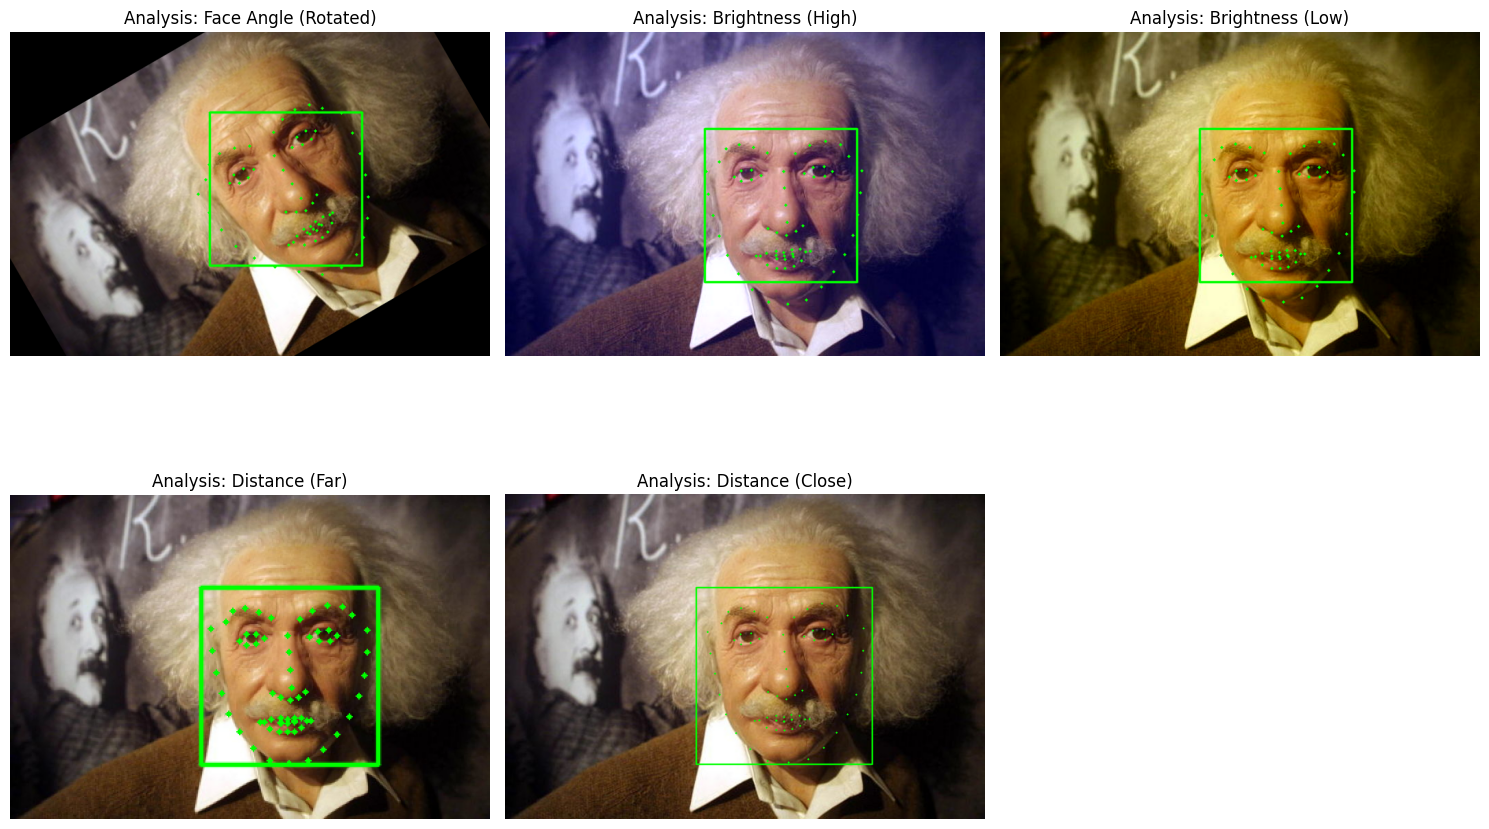

In [11]:
# --- Systematic Analysis of Detector Performance ---

def analyze_and_draw(image, title=""):
    """
    A helper function to run detection and draw the results on an image.
    This avoids repeating code for each analysis case.
    """
    img_to_process = image.copy()
    
    # Run the face detector on the provided image
    dlib_rects_test = detector_hog(img_to_process, 1)


    # If faces are found, draw the results
    for dlib_rect in dlib_rects_test:
    #     center_x = (dlib_rect.left() + dlib_rect.right()) // 2
    #     center_y = (dlib_rect.top() + dlib_rect.bottom()) // 2
    #     radius = (dlib_rect.right() - dlib_rect.left()) // 2
    # # Draw the circle instead of a rectangle
    #     cv2.circle(img_show_step1, (center_x, center_y), radius, (0, 255, 0), 2)
        # Draw the rectangle
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        cv2.rectangle(img_to_process, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
        # Draw the landmarks
        points = landmark_predictor(img_to_process, dlib_rect)
        for p in points.parts():
            cv2.circle(img_to_process, (p.x, p.y), 2, (0, 255, 0), -1)
            
    return img_to_process

# --- 1. Face Angle Analysis ---
(h, w) = img_bgr.shape[:2]
center = (w // 2, h // 2)
# Create a rotation matrix for a 30-degree rotation
rotation_matrix = cv2.getRotationMatrix2D(center, 30, 1.0)
img_rotated = cv2.warpAffine(img_bgr, rotation_matrix, (w, h))
rotated_result = analyze_and_draw(img_rotated, title="Face Angle")

# --- 2. Image Brightness Analysis ---
# Create a brighter image (add 50 to each pixel)
img_bright = cv2.add(img_bgr, np.array([50.0]))
# Create a darker image (subtract 50 from each pixel)
img_dark = cv2.subtract(img_bgr, np.array([50.0]))
bright_result = analyze_and_draw(img_bright, title="Bright Image")
dark_result = analyze_and_draw(img_dark, title="Dark Image")

# --- 3. Shooting Distance Analysis ---
# Simulate a farther distance (scale down to 50%)
img_far = cv2.resize(img_bgr, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
# Simulate a closer distance (scale up to 150%)
img_close = cv2.resize(img_bgr, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
far_result = analyze_and_draw(img_far, title="Far Distance")
close_result = analyze_and_draw(img_close, title="Close Distance")

# --- 4. Display All Analysis Results ---
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(rotated_result, cv2.COLOR_BGR2RGB))
plt.title('Analysis: Face Angle (Rotated)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(bright_result, cv2.COLOR_BGR2RGB))
plt.title('Analysis: Brightness (High)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(dark_result, cv2.COLOR_BGR2RGB))
plt.title('Analysis: Brightness (Low)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(far_result, cv2.COLOR_BGR2RGB))
plt.title('Analysis: Distance (Far)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(close_result, cv2.COLOR_BGR2RGB))
plt.title('Analysis: Distance (Close)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
######얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 비교



두 결과를 비교했을 때 face angle rotation은 그리 큰 영향을 받지 않는걸로 보인다
일부 영역의 경우 (오른쪽 눈썹) face detection 할 때 짤리는게 관측되지만 landmark prediction은 잘되고 있는게 보인다
Brightness는 정도의 상관없이 악영향을 미치는게 보이지 않는다
거리의 경우 유의미한 차이를 보인다. 거리를 조정했을 때 face detection이 턱의 전체를 포함시키는것이 관찰된다.